In [3]:
import torch
from torch import nn
from difflogic import LogicLayer, GroupSum

device = torch.device('cuda')

model = nn.Sequential(
    nn.Flatten(),
    LogicLayer(784, 8000, device='cuda', implementation='cuda'),
    LogicLayer(8000, 8000, device='cuda', implementation='cuda'),
    LogicLayer(8000, 8000, device='cuda', implementation='cuda'),
    LogicLayer(8000, 8000, device='cuda', implementation='cuda'),
    LogicLayer(8000, 8000, device='cuda', implementation='cuda'),
    GroupSum(k=10, tau=30)
).to(device)


In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # returns float in [0,1]
])

train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # difflogic recommends 0.01

model.train()
loss_epoch = []
epochs = 20
for epoch in range(epochs):
    losse = 0
    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        losse = loss
        loss.backward()
        optimizer.step()
    loss_epoch.append(losse.detach().item())
    print(f"Epoch {epoch+1} done. {loss_epoch[-1]}")


Epoch 1 done. 0.7873504757881165
Epoch 2 done. 0.4222673177719116
Epoch 3 done. 0.3417583405971527
Epoch 4 done. 0.23769181966781616
Epoch 5 done. 0.4162149727344513
Epoch 6 done. 0.29920586943626404
Epoch 7 done. 0.2593056559562683
Epoch 8 done. 0.24889713525772095
Epoch 9 done. 0.3190615773200989
Epoch 10 done. 0.2874639332294464
Epoch 11 done. 0.3008366525173187
Epoch 12 done. 0.12358328700065613
Epoch 13 done. 0.1583191454410553
Epoch 14 done. 0.2870664894580841
Epoch 15 done. 0.21859194338321686
Epoch 16 done. 0.17365558445453644
Epoch 17 done. 0.1563766896724701
Epoch 18 done. 0.31693243980407715
Epoch 19 done. 0.23810960352420807
Epoch 20 done. 0.22691942751407623


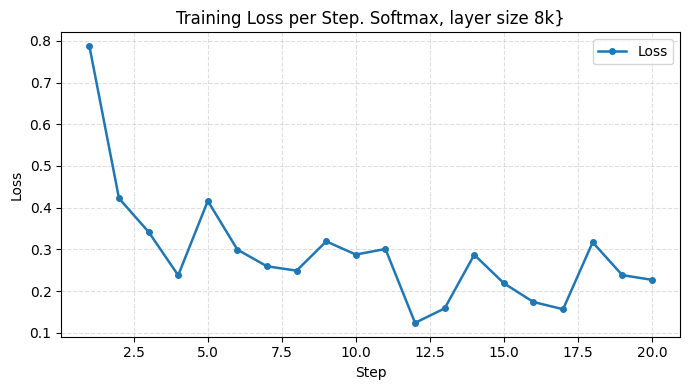

In [6]:
import matplotlib.pyplot as plt
import numpy as np

steps = np.arange(1, len(loss_epoch) + 1)

plt.figure(figsize=(7, 4))
plt.plot(steps, loss_epoch, marker='o', linewidth=1.8, markersize=4, label='Loss')
plt.title('Training Loss per Step. Softmax, layer size 8k}')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
from difflogic.packbitstensor import PackBitsTensor
import numpy as np
import time
def packbits_eval(model, loader):
    orig_mode = model.training
    start = time.perf_counter()
    with torch.no_grad():
        model.eval()
        res = np.mean(
            [
                (model(PackBitsTensor(x.to('cuda').reshape(x.shape[0], -1).round().bool())).argmax(-1) == y.to(
                    'cuda')).to(torch.float32).mean().item()
                for x, y in loader
            ]
        )
        model.train(mode=orig_mode)
    elapsed = time.perf_counter() - start
    throughput = 10_000 / elapsed
    print(f"throughput : {throughput : .1f}/s")
    return res.item()




In [15]:
packbits_eval(model,test_loader)

throughput :  19456.1/s


0.9423389673233032

In [17]:
import torch
import time
from torchvision import datasets, transforms

model.eval()
torch.cuda.synchronize()

test_ds = datasets.MNIST(root='./data', train=False, download=True,
                         transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True
)

# Warm-up
with torch.inference_mode():
    for i, (x, _) in enumerate(test_loader):
        x = x.to('cuda', non_blocking=True)
        _ = model(x)
        if i >= 2:
            break
torch.cuda.synchronize()

# Timed run with accuracy
total_images = 0
correct = 0

start = time.perf_counter()
with torch.inference_mode():
    for x, y in test_loader:
        x = x.to('cuda', non_blocking=True)
        y = y.to('cuda', non_blocking=True)
        logits = model(x)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total_images += x.size(0)

torch.cuda.synchronize()
elapsed = time.perf_counter() - start
throughput = 10000 / elapsed
accuracy = correct / total_images
error_rate = 1.0 - accuracy

print(f"Inference throughput (float inputs, eval-mode): {throughput:.1f} images/s")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Error rate: {error_rate*100:.2f}%")


Inference throughput (float inputs, eval-mode): 44677.2 images/s
Accuracy: 94.70%
Error rate: 5.30%


## compiling model into c code for cpu inference


In [18]:
import difflogic

compiled_model = difflogic.CompiledLogicNet(
    model=model,            # the trained model (should be a `torch.nn.Sequential` with `LogicLayer`s)
    num_bits=64,            # the number of bits of the datatype used for inference (typically 64 is fastest, should not be larger than batch size)
    cpu_compiler='gcc',     # the compiler to use for the c code (alternative: clang)
    verbose=True            
)
compiled_model.compile(
    save_lib_path='mnist_gumbel_tau_0_0_1_e20.so',  # the (optional) location for storing the binary such that it can be reused
    verbose=True,
)

Skipping torch.nn.Flatten layer (<class 'torch.nn.modules.flatten.Flatten'>).
Skipping GroupSum layer (<class 'difflogic.difflogic.GroupSum'>).
`layers` created and has 5 layers.
C code created and has 40062 lines. (temp location /tmp/tmp3mkpvy2h.c)
Compiling finished in 72.456 seconds.
lib_file copied from /tmp/tmp_b5que4t.so to mnist_gumbel_tau_0_0_1_e20.so .


In [ ]:
xs, ys = [],[]
for imgs, labels in test_loader:
    xs.append(imgs)
    ys.append(labels)
X = torch.cat(xs, dim=0).cpu().bool().numpy()
y = torch.cat(ys, dim=0).cpu().numpy()

: 

: 

In [ ]:
import time
import difflogic.compiled_model 
compiled_model = compiled_model.load('/home/ramganeshs/research/src/testing/mnist_softmax_8k_5l.so',10,64)
start = time.perf_counter()
output = compiled_model(X)
elapsed = time.perf_counter() - start
throughput = 10000 / elapsed
print(f"Inference throughput: {throughput:.1f} images/s")
crr = 0
for i,out in enumerate(output):
    val, idx = torch.max(out, dim=0)
    if y[i] == idx:
        crr += 1
print(f"ACC : {crr/10000}")


Inference throughput: 257523.3 images/s
ACC : 0.9378


: 

: 

In [ ]:
compiled_model(X)

tensor([[315, 205, 384,  ..., 681, 308, 389],
        [373, 311, 567,  ..., 221, 401, 235],
        [213, 584, 397,  ..., 380, 398, 301],
        ...,
        [268, 211, 280,  ..., 384, 443, 438],
        [338, 302, 299,  ..., 279, 478, 290],
        [365, 248, 436,  ..., 240, 346, 304]], dtype=torch.int32)

: 

: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Config
batch_size = 128
epochs = 3
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data (MNIST 28x28 grayscale)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_ds = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST("./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Simple CNN
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 16, 3, padding=1)   # 28x28 -> 28x28
        self.c2 = nn.Conv2d(16, 32, 3, padding=1)  # 28x28 -> 28x28
        self.p  = nn.MaxPool2d(2)                  # 28x28 -> 14x14
        self.f1 = nn.Linear(32*14*14, 64)
        self.f2 = nn.Linear(64, 10)
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = self.p(F.relu(self.c2(x)))
        x = x.flatten(1)
        x = F.relu(self.f1(x))
        return self.f2(x)

model = CNN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)
crit = nn.CrossEntropyLoss()

def accuracy(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

# Throughput helpers using CUDA events
def measure_epoch_throughput(train_loader):
    if device.type != "cuda":
        return None
    start = torch.cuda.Event(enable_timing=True)
    end   = torch.cuda.Event(enable_timing=True)
    total_images = 0
    torch.cuda.synchronize()
    start.record()
    for x, y in train_loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        out = model(x)
        loss = crit(out, y)
        loss.backward()
        opt.step()
        total_images += x.size(0)
    end.record()
    torch.cuda.synchronize()
    ms = start.elapsed_time(end)  # milliseconds
    images_per_sec = total_images / (ms / 1000.0)
    return images_per_sec

def measure_inference_throughput(test_loader, warmup_batches=5):
    if device.type != "cuda":
        return None
    # Warmup
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(device, non_blocking=True)
            _ = model(x)
            if i >= warmup_batches:
                break
    torch.cuda.synchronize()
    start = torch.cuda.Event(enable_timing=True)
    end   = torch.cuda.Event(enable_timing=True)
    total_images = 0
    start.record()
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device, non_blocking=True)
            _ = model(x)
            total_images += x.size(0)
    end.record()
    torch.cuda.synchronize()
    ms = start.elapsed_time(end)
    images_per_sec = total_images / (ms / 1000.0)
    return images_per_sec

# Training loop
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    n = 0

    # Measure throughput over the whole epoch (train)
    train_ips = measure_epoch_throughput(train_loader)

    # After throughput pass, we already updated model; compute train stats quickly on a small subset
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            out = model(x)
            loss = crit(out, y)
            train_loss += loss.item() * x.size(0)
            train_acc += (out.argmax(1) == y).float().sum().item()
            n += x.size(0)
            if i >= 50:  # keep it light
                break
    train_loss /= n
    train_acc /= n

    # Eval accuracy on test set
    test_loss = 0.0
    test_acc = 0.0
    m = 0
    print(f"Epoch {epoch}: "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} ")


with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        out = model(x)
        loss = crit(out, y)
        test_loss += loss.item() * x.size(0)
        test_acc  += (out.argmax(1) == y).float().sum().item()
        m += x.size(0)
test_loss /= m
test_acc  /= m
infer_ips = measure_inference_throughput(test_loader)
print(f"Inference throughput: {infer_ips:.0f} images/sec")
print(f"test_loss={test_loss:.4f} test_acc={test_acc:.4f}")


Using device: cuda
Epoch 1: train_loss=0.0570 train_acc=0.9818 
Epoch 2: train_loss=0.0456 train_acc=0.9848 
Epoch 3: train_loss=0.0271 train_acc=0.9917 
Inference throughput: 22373 images/sec
test_loss=0.0394 test_acc=0.9871


: 

: 

: 

: 